### PCA
PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. In this 2D example there is no choice: it is the dotted line. If it were a  higherdimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on — as many axes as the number of dimensions in the dataset. The unit vector that defines the ith axis is called the ith principal component (PC). The 1st PC is c_1 and the 2nd PC is c_2.

### PCA using SVD decomposition
A = U . Sigma . V^T
Where A is the real m x n matrix that we wish to decompose, U is an m x m matrix, Sigma (often represented by the uppercase Greek letter Sigma) is an m x n diagonal matrix, and V^T is the  transpose of an n x n matrix where T is a superscript. V^T contains all the principal components that we are looking for

In [1]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#Build 3D dataset:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3* np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

### PCA using Scikit-Learn
The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automatically takes care of centering the data)

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

In [12]:
#Recover the 3D points projected on the plane (PCA 2D subspace)
X3D_inv = pca.inverse_transform(X2D)
np.allclose(X3D_inv, X)

False

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points.

In [13]:
#compute the reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis = 1))

0.010170337792848549

In [14]:
#The inverse transform in the SVD approach:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

After fitting the PCA transformer to the dataset, you can access the principal components using the components_ variable (note that it contains the PCs as horizontal vectors, so, for example, the first principal component is equal to pca.components_.T[:, 0]).

In [15]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [16]:
Vt[:2] # axes are flipped

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

### Explained Variance Ratio
Another very useful piece of information is the explained variance ratio of each principal component, available via the explained_variance_ratio_ variable. It indicates the proportion of the dataset’s variance that lies along the axis of each principal component.

In [17]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [18]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that s is the diagonal of the matrix S):

In [19]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [20]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [21]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

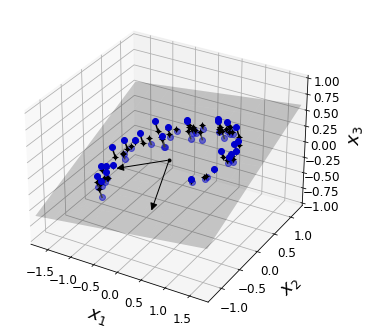

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 5.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

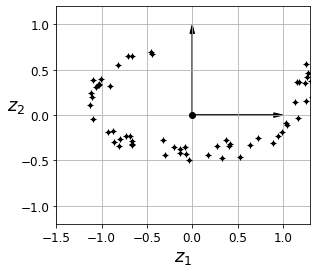

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

### MNIST compression

In [24]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version =1)
mnist.target = mnist.target.astype(np.uint8)

In [25]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Choosing the Right Number of Dimensions
Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%).
Unless, of course, you are reducing dimensionality for data visualization — in that case you will generally want to reduce the dimensionality down to 2 or 3. 
The following code computes PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance:

In [26]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [27]:
d

154

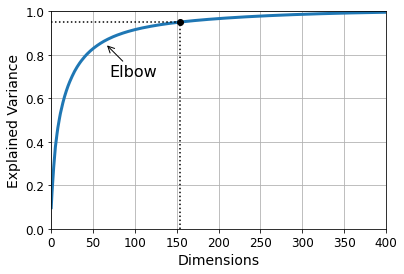

In [28]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

**n_components**  if 0 < n_components < 1, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components

In [29]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

In [30]:
pca.n_components_

154

In [31]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

### PCA for Compression
Obviously after dimensionality reduction, the training set takes up much less space. For example, try applying PCA to the MNIST dataset while preserving 95% of its variance. You should find that each instance will have just over 150 features, instead of the original 784 features. So while most of the
variance is preserved, the dataset is now less than 20% of its original size! This is a reasonable compression ratio, and you can see how this can speed up a classification algorithm (such as an SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. Of course this won’t give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be quite close to the original data

In [32]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [33]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

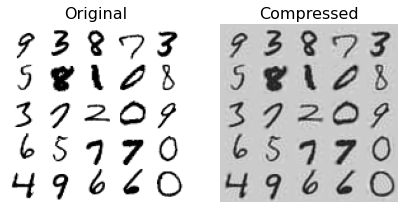

In [34]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


In [35]:
X_reduced_pca = X_reduced

### Incremental PCA

One problem with the preceding implementation of PCA is that it requires the whole training set to fit in memory in order for the SVD algorithm to run. Fortunately, Incremental PCA (IPCA) algorithms have been developed: you can split the training set into mini-batches and feed an IPCA algorithm one minibatch at a time. This is useful for large training sets, and also to apply PCA online

In [36]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    print('.', end = '')
    inc_pca.partial_fit(X_batch) #call the partial_fit() method with each mini-batch rather than the fit() method with the whole training set
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [37]:
X_reduced_inc_pca = X_reduced

In [38]:
np.allclose(pca.mean_, inc_pca.mean_)

True

### Using memmap()
Alternatively, we can use NumPy’s memmap class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory,
when it needs it. 

In [39]:
import os
import numpy as np 
filename = "my_mnist_.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [40]:
del X_mm

In [41]:
#Next, another program would load the data and use it for training:
X_mm = np.memmap(filename, dtype = 'float32', mode = 'readonly', 
                shape = (m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

### Randomized PCA

In [42]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Time complexity
Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [43]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 27.8 seconds
    IncrementalPCA: 7.8 seconds
    PCA: 28.0 seconds
n_components = 10
    PCA: 44.8 seconds
    IncrementalPCA: 7.8 seconds
    PCA: 46.1 seconds
n_components = 154
    PCA: 234.2 seconds
    IncrementalPCA: 9.4 seconds
    PCA: 231.6 seconds


### Kernel PCA


In [44]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)

In [45]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

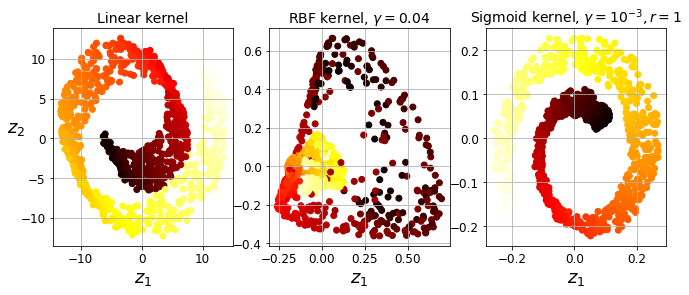

In [46]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel = 'linear', 
                    fit_inverse_transform = True)

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', 
                    gamma=0.0433, fit_inverse_transform=True)

sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", 
                    gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

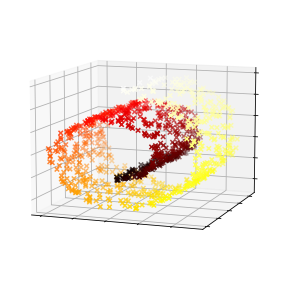

In [47]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

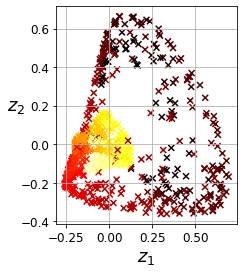

In [48]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

### Selecting a Kernel and Tuning Hyperparameters
As kPCA is an unsupervised learning algorithm, there is no obvious  performance measure to help you select the best kernel and hyperparameter values. However, dimensionality reduction is often a preparation step for a supervised learning task (e.g., classification), so you can simply use grid search to select the kernel and hyperparameters that lead to the best performance on that task. For example, the following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applying Logistic Regression for classification. Then it uses GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components = 2)),
    ('log_reg', LogisticRegression(solver = 'lbfgs'))
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [50]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [51]:
rbf_pca = KernelPCA(n_components = 2, kernel= 'rbf', gamma = 0.0433,
                   fit_inverse_transform = True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [52]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

1.6144557497877967e-26

### LLE

LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved. This makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise. In LLE, distances are not preserved on a larger scale.

In [53]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [54]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10, 
                            random_state = 42)
X_reduced = lle.fit_transform(X)

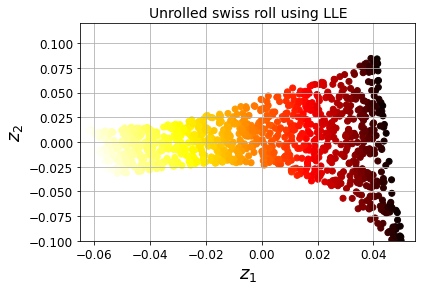

In [55]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

### MDS, Isomap and t-SNE

In [56]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [57]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

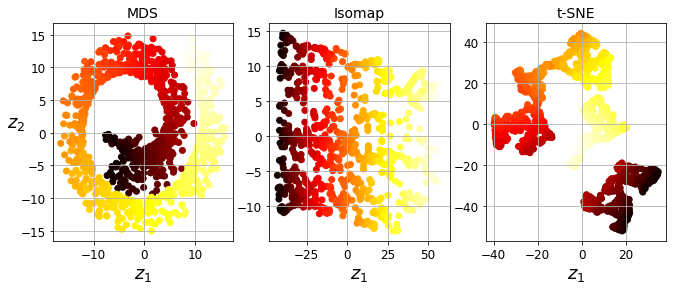

In [60]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [61]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [62]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [63]:
import time
t1 = time.time()
rnd_clf.fit(X_train, y_train)
t2 = time.time()

In [64]:
print('Training took {:.2f}s'.format(t2 - t1))

Training took 38.05s


In [65]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

Use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)

In [67]:
rnd_clf2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
t1 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t2 = time.time()

In [68]:
print('Training time is {:.2f}s'.format(t2 - t1))

Training time is 88.49s


Training is actually more than three times slower now! Well, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. 

In [69]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance.

In [70]:
#try softmax regression
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs',
                            random_state = 42)

t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [71]:
print('Training took {:.2f}s'.format(t1 - t0))

Training took 609.19s


In [72]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [73]:
log_clf2 = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs',
                            random_state = 42)

t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [74]:
print('Training took {:.2f}s'.format(t1 - t0))

Training took 117.48s


In [75]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance, which might be a reasonable price to pay for a 5× speedup, depending on the application.

PCA can give you a formidable speedup... but not always!

### Use t-SNE to reduce the MNIST dataset down to two dimensions

In [76]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]
X = mnist['data'][idx]
y = mnist['target'][idx]

In [77]:
# now lets use t-SNE to reduce dimensionality down to 
#2D so we can plot the dataset

from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state = 42)
X_reduced = tsne.fit_transform(X)

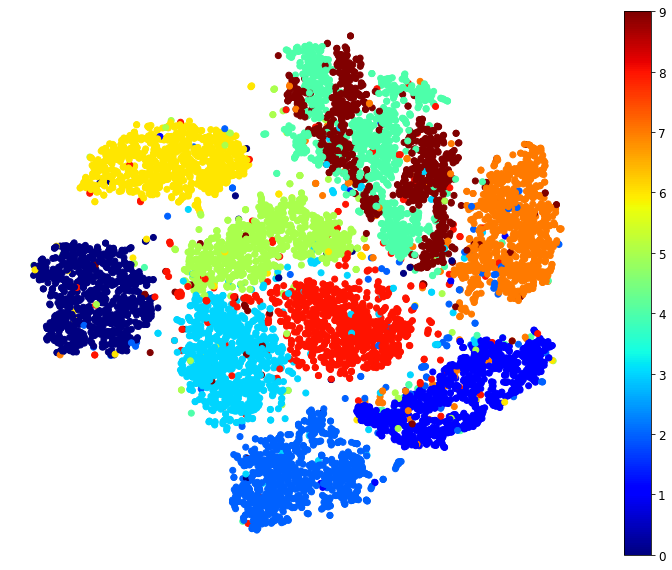

In [78]:
plt.figure(figsize = (13, 10))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y, cmap= 'jet')
plt.axis('off')
plt.colorbar()
plt.show()

This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 3 and 5, which seem to overlap a lot.

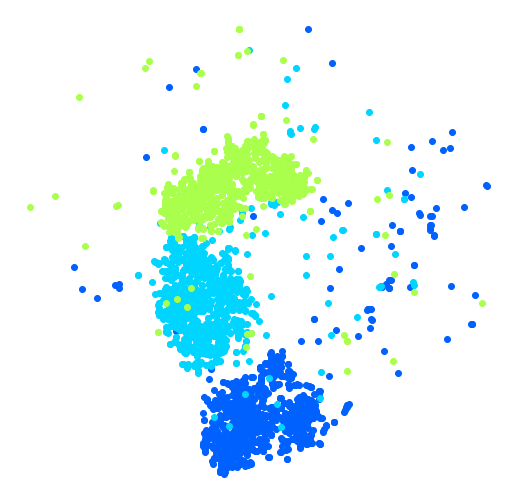

In [79]:
plt.figure(figsize = (9, 9))
cmap = mpl.cm.get_cmap('jet')
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y== digit, 0], X_reduced[y== digit, 1], c = [
        cmap(digit/9)])
    
plt.axis('off')
plt.show()

In [80]:
idx = (y==2) |(y==3) | (y==5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components = 2, random_state = 42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

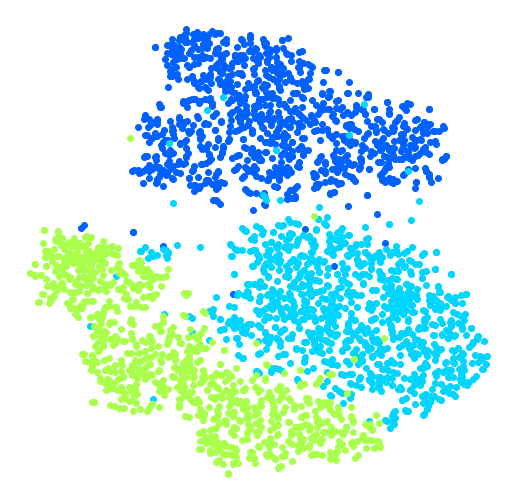

In [81]:
plt.figure(figsize = (9, 9))
cmap = mpl.cm.get_cmap('jet')
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset== digit, 0], X_subset_reduced[y_subset== digit, 1], c = [
        cmap(digit/9)])
    
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now.

Let's create a plot_digits() function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples (plot_lle_digits, based on a different digit dataset).

In [82]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

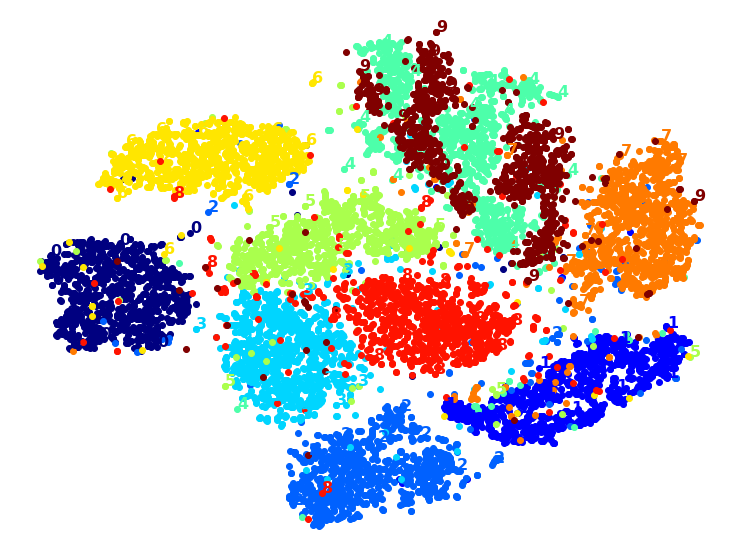

In [83]:
plot_digits(X_reduced, y)

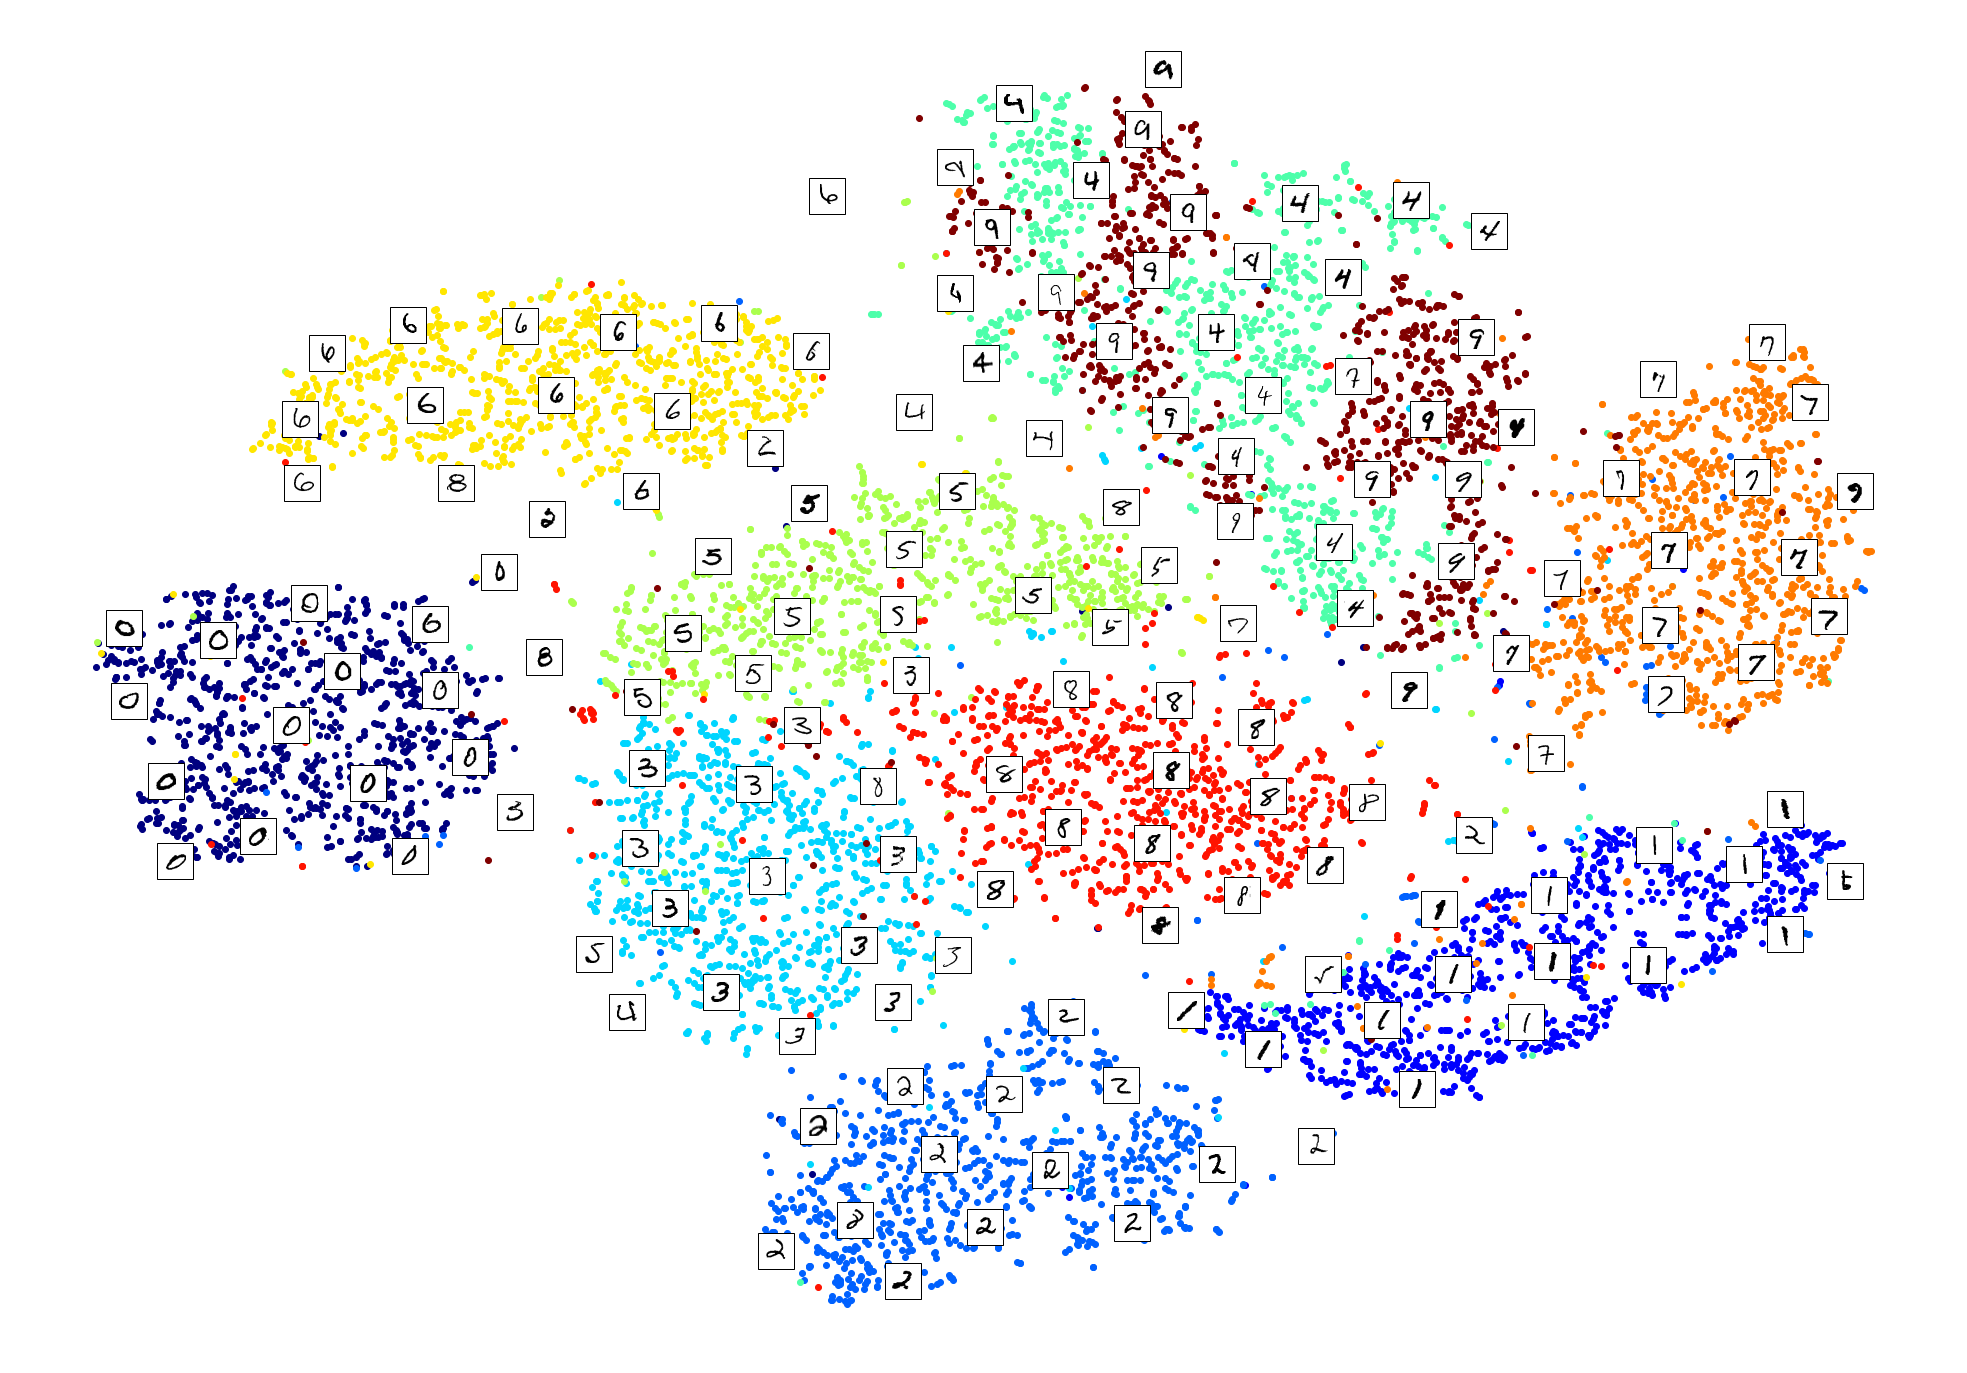

In [84]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

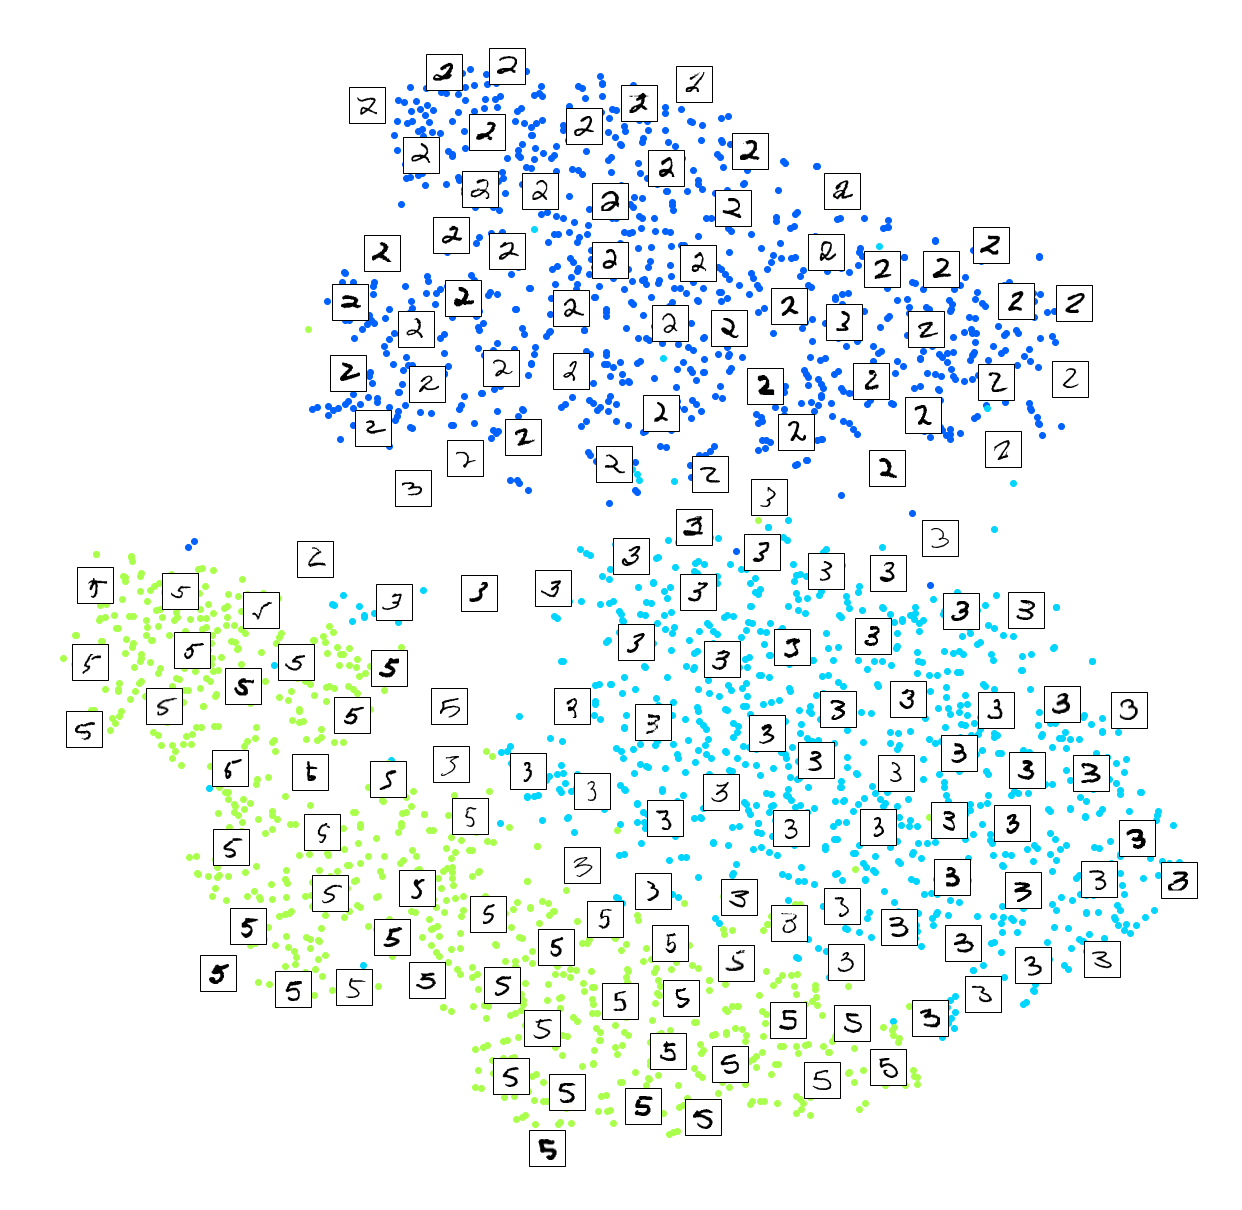

In [85]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA took 4.1s.


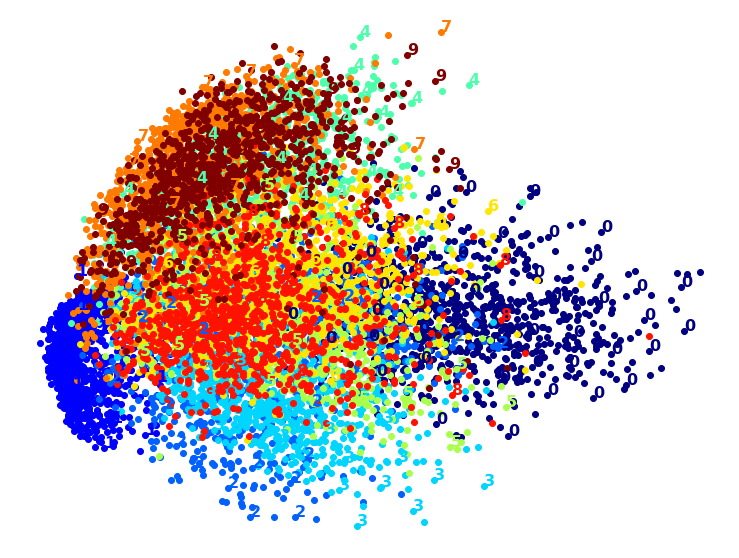

In [86]:
t0 = time.time()
X_pca_reduced = PCA(n_components = 2, random_state = 42).fit_transform(X)
t1 = time.time()
print('PCA took {:.1f}s.'.format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

LLE took 134.8s.


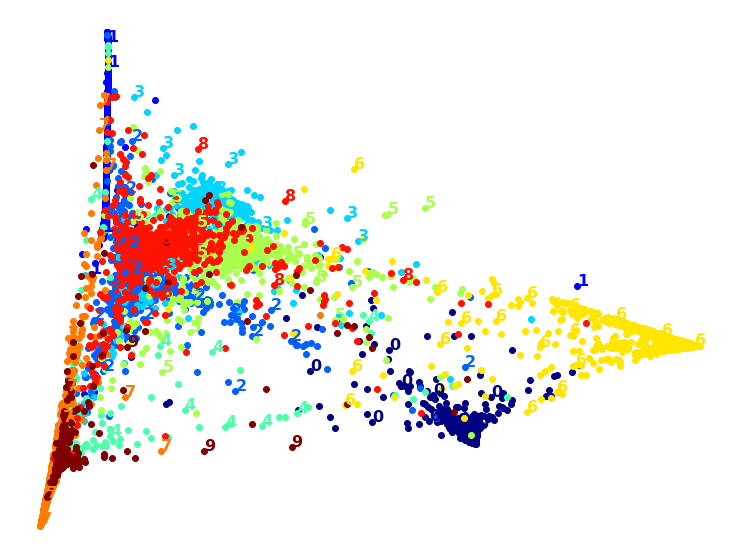

In [87]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components = 2, random_state = 42).fit_transform(X)
t1 = time.time()
print('LLE took {:.1f}s.'.format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA + LLE took 36.7s.


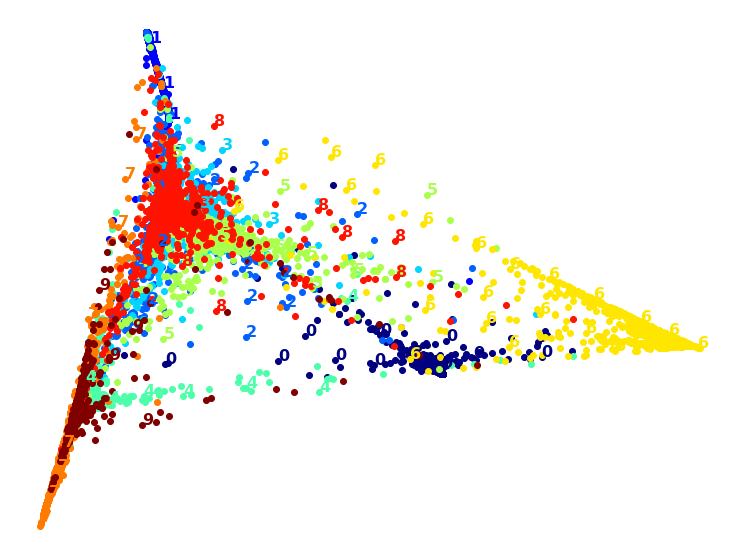

In [88]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ('pca', PCA(n_components = 0.95, random_state = 42)),
    ('lle', LocallyLinearEmbedding(n_components = 2, random_state = 42))
])

t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print('PCA + LLE took {:.1f}s.'.format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

MDS took 2005.9s.


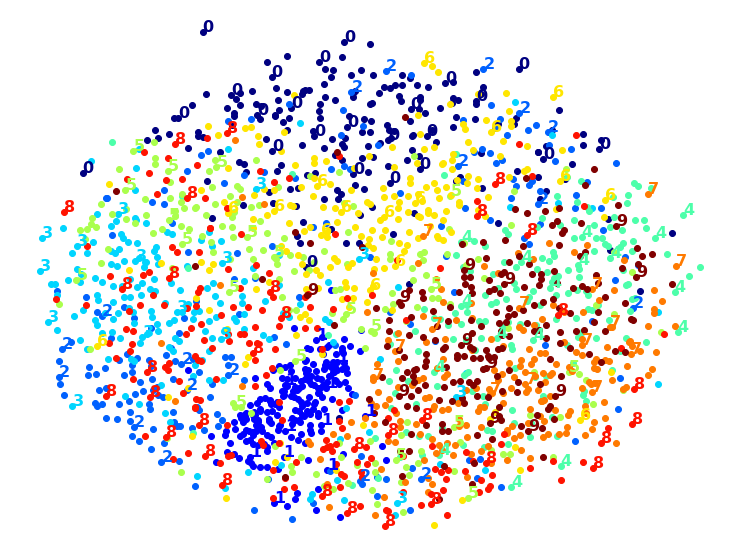

In [89]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components = 2, random_state = 42).fit_transform(X[:m])
t1 = time.time()
print('MDS took {:.1f}s.'.format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

PCA + MDS took 154.9s.


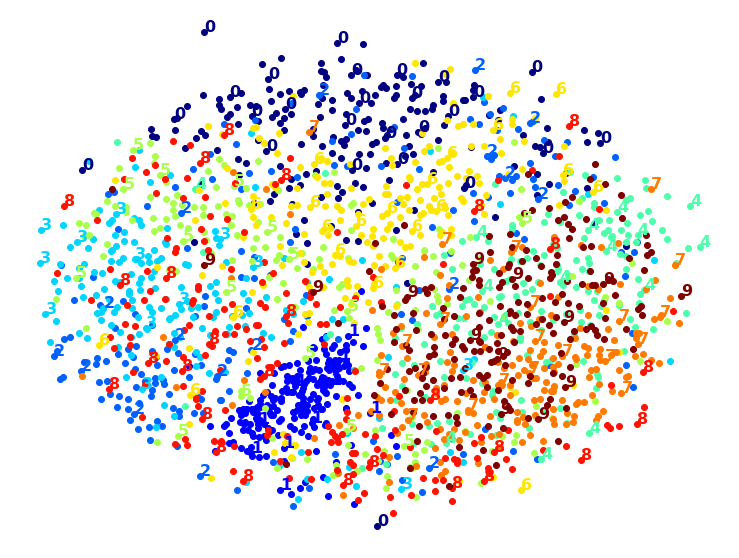

In [90]:
pca_mds = Pipeline([
    ('PCA', PCA(n_components = 0.95, random_state = 42)),
    ('MDS', MDS(n_components = 2, random_state = 42))
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:m])
t1 = time.time()
print('PCA + MDS took {:.1f}s.'.format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:m])
plt.show()

LDA took 1.5s.


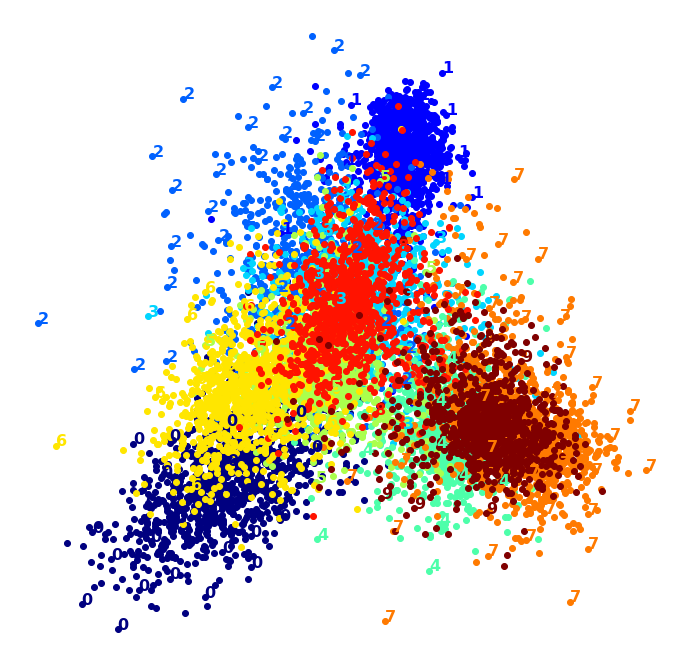

In [91]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components = 2).fit_transform(X, y)
t1 = time.time()
print('LDA took {:.1f}s.'.format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize = (12, 12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this competition. let's time it now:

PCA+t-SNE took 91.6s.


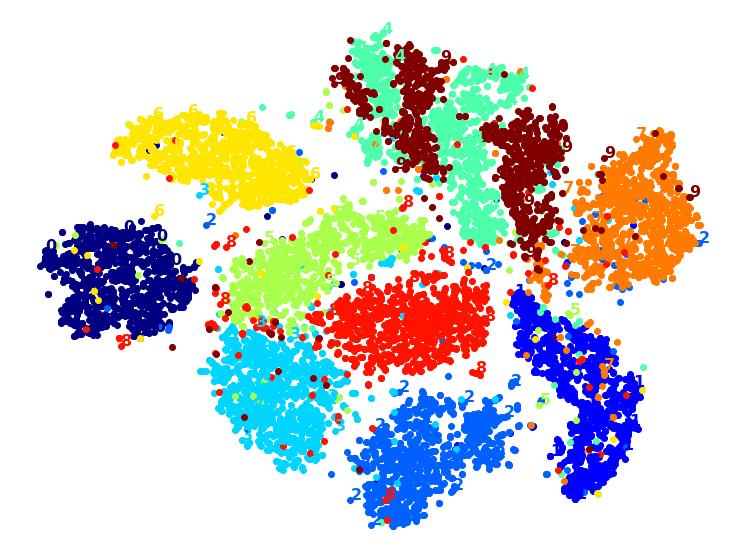

In [92]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()